
Total samples: 9418, Training samples: 7534, Validation samples: 1884


83683744/83683744 [==============================] - 10s 0us/step


Epoch 1/20



235/235 [==============================] - 2126s 9s/step - loss: 0.4867 - accuracy: 0.7895 - val_loss: 0.4531 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 2/20
235/235 [==============================] - 2064s 9s/step - loss: 0.4210 - accuracy: 0.8070 - val_loss: 0.4375 - val_accuracy: 0.7991 - lr: 0.0010
Epoch 3/20
235/235 [==============================] - 2079s 9s/step - loss: 0.3921 - accuracy: 0.8194 - val_loss: 0.4418 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 4/20
235/235 [==============================] - 2143s 9s/step - loss: 0.3702 - accuracy: 0.8342 - val_loss: 0.4389 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 5/20
235/235 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8363Restoring model weights from the end of the best epoch: 2.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
235/235 [==============================] - 2256s 10s/step - loss: 0.3499 - accuracy: 0.8363 - val_loss: 0.4654 - val_accuracy: 0.7981 - lr: 0.0010
Epoc

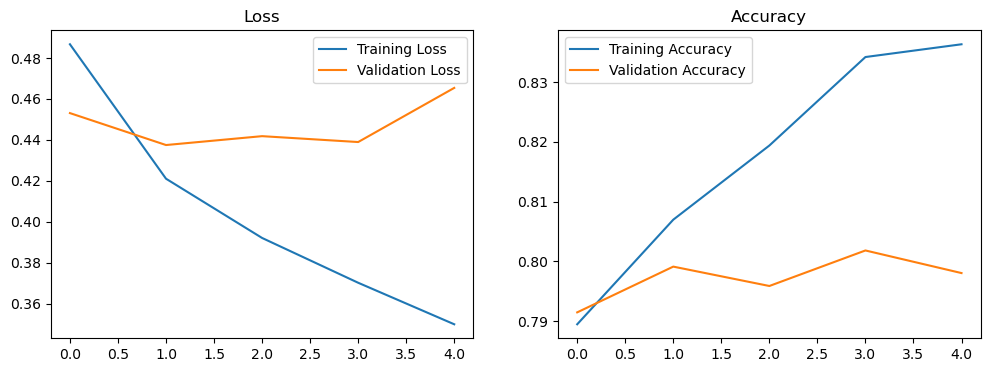

In [1]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications.xception import Xception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def image_generator(image_paths, labels, batch_size=32):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_images = [prepare_image(path) for path in batch_paths]
            yield np.array(batch_images), np.array(batch_labels)

def prepare_image(image_path):
    img = load_img(image_path, target_size=(299, 299))  # Xception's default input size is (299, 299)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to be between 0 and 1
    return img_array

X = []
Y = []

# Real images from CASIA2
real_path_casia2 = "C:\\Users\\vamsi\\Downloads\\archive (1)\\CASIA2\\Au\\"
for dirname, _, filenames in os.walk(real_path_casia2):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(full_path)
            Y.append(1)

# Fake images from CASIA2
fake_path_casia2 = "C:\\Users\\vamsi\\Downloads\\archive (1)\\CASIA2\\Tp\\"
for dirname, _, filenames in os.walk(fake_path_casia2):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(full_path)
            Y.append(0)

# Convert labels to categorical
Y = to_categorical(Y, 2)

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f'Total samples: {len(X)}, Training samples: {len(X_train)}, Validation samples: {len(X_val)}')

# Create Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generator for training data
train_data_generator = image_generator(X_train, Y_train, batch_size=32)

# Generator for validation data
val_data_generator = image_generator(X_val, Y_val, batch_size=32)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=3,
                               verbose=1,
                               restore_best_weights=True
                               )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)

callbacks_list = [early_stopping, reduce_learningrate]

model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model using the generators
history = model.fit(
    train_data_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=val_data_generator,
    validation_steps=len(X_val) // 32,
    callbacks=callbacks_list
)

# Evaluate the model
score = model.evaluate(val_data_generator, steps=len(X_val) // 32, verbose=0)
print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


In [2]:
from sklearn import metrics

# Assuming you have your test data and predictions
y_test_predicted = model.predict(val_data_generator, steps=len(X_val) // 32+1)
y_test_predicted = np.argmax(y_test_predicted, axis=1)

y_train_predicted = model.predict(train_data_generator, steps=len(X_train) // 32+1)
y_train_predicted = np.argmax(y_train_predicted, axis=1)

# Calculate and print various metrics
enetp = metrics.precision_score(np.argmax(Y_val, axis=1), y_test_predicted) * 100
enet_t = metrics.precision_score(np.argmax(Y_train, axis=1), y_train_predicted) * 100
print("Precision of test:", enetp)
print("Precision of train:", enet_t)

enetr = metrics.recall_score(np.argmax(Y_val, axis=1), y_test_predicted) * 100
enetr_t = metrics.recall_score(np.argmax(Y_train, axis=1), y_train_predicted) * 100
print("Recall of test:", enetr)
print("Recall of train:", enetr_t)

ef = metrics.f1_score(np.argmax(Y_val, axis=1), y_test_predicted) * 100
ef_t = metrics.f1_score(np.argmax(Y_train, axis=1), y_train_predicted) * 100
print("F1 score of test:", ef)
print("F1 score of train:", ef_t)



236/236 [==============================] - 1716s 7s/step
Precision of test: 76.65441176470588
Precision of train: 78.20922795797168
Recall of test: 86.21640248104755
Recall of train: 87.00660681009657
F1 score of test: 81.15471942912748
F1 score of train: 82.37369687249398


Confusion Matrix - Test Data:
[[  52  381]
 [ 200 1251]]

Confusion Matrix - Train Data:
[[ 200 1431]
 [ 767 5136]]


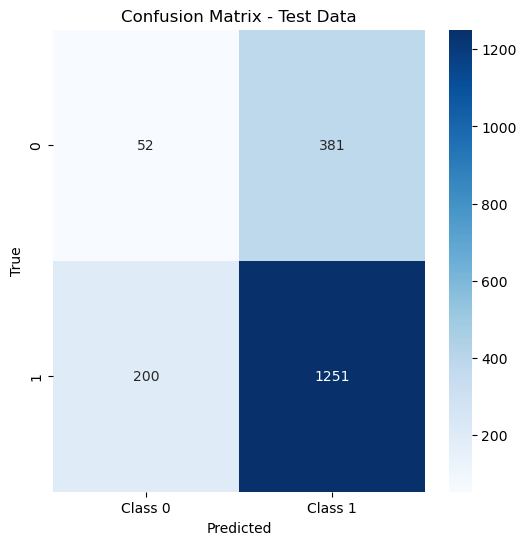

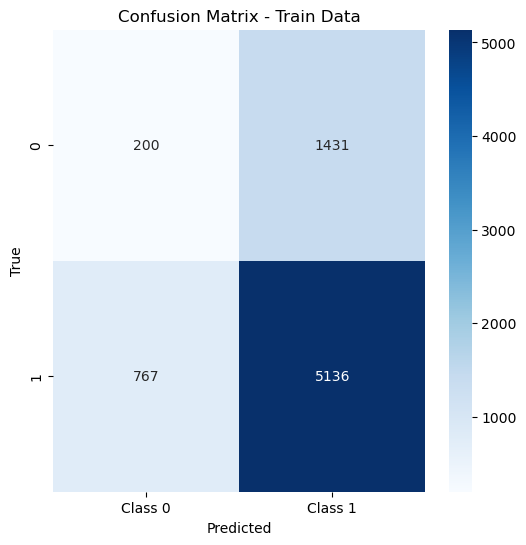

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm_test = confusion_matrix(np.argmax(Y_val, axis=1), y_test_predicted)
cm_train = confusion_matrix(np.argmax(Y_train, axis=1), y_train_predicted)
print("Confusion Matrix - Test Data:")
print(cm_test)

print("\nConfusion Matrix - Train Data:")
print(cm_train)
# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure(figsize=(6, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - Train Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()